In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 26.3MB/s 
     |████████████████████████████████| 1.8MB 47.4MB/s 
     |████████████████████████████████| 1.2MB 50.2MB/s 
     |████████████████████████████████| 51kB 10.2MB/s 
     |████████████████████████████████| 194kB 48.4MB/s 
     |████████████████████████████████| 133kB 60.5MB/s 
     |████████████████████████████████| 102kB 15.6MB/s 
     |████████████████████████████████| 174kB 58.2MB/s 
     |████████████████████████████████| 61kB 11.5MB/s 
     |████████████████████████████████| 61kB 11.4MB/s 
     |████████████████████████████████| 71kB 13.6MB/s 


In [2]:
from fastbook import *
from fastai.callback.tracker import SaveModelCallback

import numpy as np
from tqdm.auto import tqdm
from plotnine import *
import shutil

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/images_xray.zip" -d "/content/drive/MyDrive/images_xray/"

In [5]:
path = Path('/content/drive/MyDrive/images_xray/images/')

In [7]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(512, method=ResizeMethod.Squish), 
    batch_tfms = [IntToFloatTensor(), Brightness(max_lighting = 0.2, p = 0.2), Contrast(max_lighting = 0.4, p = 0.4), *aug_transforms(size=512, flip_vert=True), Normalize.from_stats(*imagenet_stats)]
    )
dls = dblock.dataloaders(path, bs=64)

In [8]:
xb, yb = dls.one_batch()

xb.shape, yb.shape

(torch.Size([64, 3, 512, 512]), torch.Size([64]))

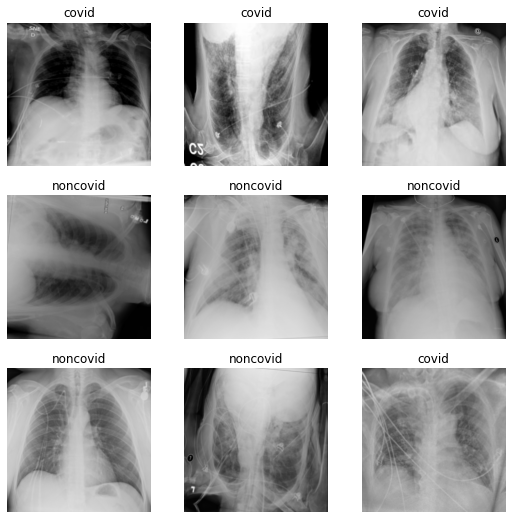

In [9]:
dls.train.show_batch(max_n=9, nrows=3)

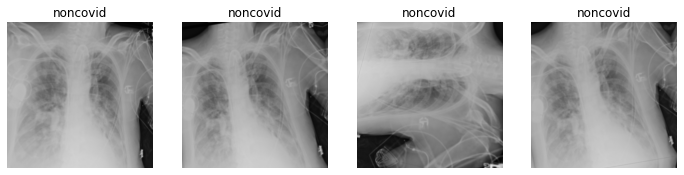

In [10]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [11]:
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, 
                             Precision(), 
                             Recall(), 
                             F1Score()]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [12]:
defaults.device = torch.device('cuda')

In [13]:
learn.fine_tune(epochs=10,
          base_lr=1e-3,
          freeze_epochs=1,
          lr_mult=100,
          pct_start=0.2,
          div=5.0,
          cbs=[SaveModelCallback(monitor='f1_score')]
          )

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.534357,0.282611,0.910833,0.880805,0.949917,0.914056,12:02


Better model found at epoch 0 with f1_score value: 0.9140562248995984.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.325399,0.210336,0.942500,0.920635,0.968280,0.943857,01:23
1,0.235486,0.210033,0.945833,0.930645,0.963272,0.946678,01:22
2,0.219670,0.225573,0.933333,0.894977,0.981636,0.936306,01:22
3,0.168068,0.155825,0.954167,0.934505,0.976628,0.955102,01:22
4,0.144384,0.143352,0.960000,0.945073,0.976628,0.960591,01:22
5,0.121823,0.134600,0.957500,0.941935,0.974958,0.958162,01:22
6,0.107553,0.153664,0.959167,0.939297,0.981636,0.960000,01:22
7,0.097301,0.162455,0.958333,0.932283,0.988314,0.959481,01:22
8,0.087878,0.137265,0.960833,0.940895,0.983306,0.961633,01:22
9,0.084126,0.141969,0.958333,0.936407,0.983306,0.959283,01:22


Better model found at epoch 0 with f1_score value: 0.9438567941415785.
Better model found at epoch 1 with f1_score value: 0.9466776045939294.
Better model found at epoch 3 with f1_score value: 0.9551020408163265.
Better model found at epoch 4 with f1_score value: 0.9605911330049262.
Better model found at epoch 8 with f1_score value: 0.9616326530612245.


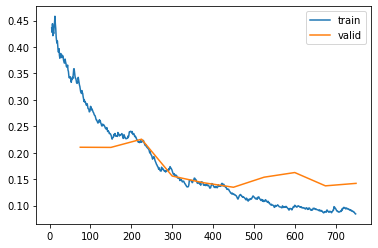

In [14]:
learn.recorder.plot_loss()

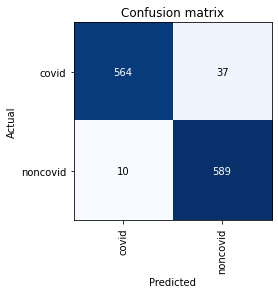

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [25]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]